### Moirai

Github: https://github.com/SalesforceAIResearch/uni2ts

Huggingface: https://huggingface.co/Salesforce/moirai-1.0-R-large

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/THESIS/rag-thesis'

/content/drive/MyDrive/THESIS/rag-thesis


In [ ]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git

Cloning into 'uni2ts'...
remote: Enumerating objects: 962, done.
remote: Counting objects: 100% (477/477), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 962 (delta 335), reused 264 (delta 264), pack-reused 485 (from 1)
Receiving objects: 100% (962/962), 8.28 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (464/464), done.
Updating files: 100% (252/252), done.


In [ ]:
cd '/content/drive/MyDrive/THESIS/rag-thesis/uni2ts'

/content/drive/MyDrive/THESIS/rag-thesis/uni2ts


In [ ]:
!pip install torch==2.4.0 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.1/799.1 MB 1.2 MB/s eta 0:00:00
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.19.0%2Bcu121-cp311-cp311-linux_x86_64.whl (7.1 MB)


In [ ]:
!pip -q install -e '.[notebook]'

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 53.2 MB/s eta

In [ ]:
!touch .env

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import torch
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

In [ ]:
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
def run_ar_benchmark(train_data, test_data, target_var, ar_order=1, horizon=1):
    """
    Runs an AR(p) model on the transformed dataset and returns performance metrics.

    Args:
        train_data (pd.DataFrame): Training data
        test_data (pd.DataFrame): Test data
        target_var (str): Target variable name
        ar_order (int): Order of the AR model
        horizon (int): Number of future points to forecast
    """
    # Ensure the index has frequency information
    if not isinstance(train_data.index, pd.DatetimeIndex) or train_data.index.freq is None:
        train_data.index = pd.date_range(
            start=train_data.index[0],
            periods=len(train_data),
            freq='Q'
        )

    # Fit AR(p) model
    model = AutoReg(train_data[target_var], lags=ar_order)
    model_fit = model.fit()

    # Make predictions for the next h points
    predictions = model_fit.forecast(steps=horizon)

    # Get the actual values for the first h points of test data
    actuals = test_data[target_var][:horizon]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

In [ ]:
# Load dataframe
df = pd.read_csv('/content/drive/MyDrive/THESIS/rag-thesis/data/processed_FRED_data.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)
variables = list(df.select_dtypes(include=[np.number]).columns)
df

,GDP_log,XTIMVA01USM664S_log,XTEXVA01USM664S_log,GPDI_log,RPI_log,INDPRO_log,BUSLOANS_log,NONREVSL_log,UNRATE_diff,DFF_diff,GS1_diff,AAA_diff,IRLTLT01USM156N_diff,M1V,CUMFNS,CLF16OV,B235RC1Q027SBEA,ROWFDIQ027S,CPILFESL_inflation,PCEPI_inflation
observation_date,,,,,,,,,,,,,,,,,,,,
1960-04-01,-1.889106,-1.937830,-1.900735,-1.933337,-1.969102,-2.223121,-1.891318,-1.855541,0.143477,-0.270617,-0.991366,-0.273408,-0.492671,-1.208557,0.410447,-1.730502,-0.917074,-0.751348,-1.084373,-0.461731
1960-07-01,-1.882088,-1.966669,-1.884644,-1.940230,-1.964744,-2.260716,-1.847751,-1.841514,0.420758,-0.880542,-1.133084,-0.381349,-0.925014,-1.210446,-0.080174,-1.724082,-0.920047,-0.750873,-1.585535,-0.688792
1960-10-01,-1.890482,-2.003349,-1.890457,-2.047059,-1.966695,-2.316039,-1.805262,-1.830178,1.113960,-0.742446,-0.112715,0.023429,0.134228,-1.227453,-0.698059,-1.713532,-0.921271,-0.752034,-0.573631,-0.579965
1961-01-01,-1.882994,-2.008331,-1.877366,-2.021036,-1.951916,-2.350629,-1.773634,-1.821522,0.698039,-0.362681,-0.169402,-0.138482,-0.211647,-1.220367,-1.108528,-1.704369,-0.921796,-0.750767,-1.086546,-0.984947
1961-04-01,-1.866870,-2.003468,-1.911936,-1.962365,-1.926400,-2.262478,-1.750164,-1.825352,0.282117,-0.305141,0.099862,0.023429,0.004525,-1.198636,-0.596247,-1.704078,-0.922670,-0.750318,-0.916503,-1.296390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,1.436028,1.213070,1.285307,1.444928,1.501814,1.137583,1.229209,1.545975,0.282117,0.304784,0.638390,0.832985,1.215087,-2.314943,-0.246743,1.425838,2.504592,0.907744,-0.275020,-0.228830
2023-10-01,1.445893,1.216451,1.284562,1.451383,1.515121,1.127452,1.229436,1.545675,0.143477,0.074624,-0.240261,0.806000,0.631423,-2.296519,-0.351921,1.432710,2.512636,0.775326,-0.134930,-0.631986
2024-01-01,1.455579,1.227645,1.290731,1.460634,1.539558,1.117367,1.236763,1.547141,0.004836,-0.005932,-0.452838,-0.651201,-0.600757,-2.286126,-0.435661,1.426999,2.630025,0.969136,0.193151,0.053674


In [13]:
print('hello')

hello


In [ ]:
def run_moirai(df, ratio=0.7):
    variables = list(df.select_dtypes(include=[np.number]).columns)
    # Horizons to evaluate
    horizons = [1,3,6,12]
    results = {
        h: {
            'RMSE': [],
            'cum_RMSE': {var:[] for var in variables}
        } for h in ["h=1", "h=3", "h=6", "h=12"]
    }

    for h in horizons:
        print(f"Running for horizon {h}...")
        MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
        SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
        PDT = h  # prediction length: any positive integer
        CTX = 200  # context length: any positive integer
        PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
        BSZ = 32  # batch size: any positive integer
        TEST = 79  # test set length: any positive integer

        # Convert into GluonTS dataset
        ds = PandasDataset(dict(df),freq='Q')

        # Split into train/test set
        train, test_template = split(
            ds, offset=-TEST
        )  # assign last TEST time steps as test set

        # Construct rolling window evaluation
        test_data = test_template.generate_instances(
            prediction_length=PDT,  # number of time steps for each prediction
            windows=60,  # number of windows in rolling window evaluation
            distance=1,  # number of time steps between each window - distance=PDT for non-overlapping windows
        )

        # Prepare model
        if MODEL == "moirai":
            model = MoiraiForecast(
                module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
                prediction_length=PDT,
                context_length=CTX,
                patch_size=PSZ,
                num_samples=100,
                target_dim=1,
                feat_dynamic_real_dim=ds.num_feat_dynamic_real,
                past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
            )
        elif MODEL == "moirai-moe":
            model = MoiraiMoEForecast(
                module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
                prediction_length=PDT,
                context_length=CTX,
                patch_size=16,
                num_samples=100,
                target_dim=1,
                feat_dynamic_real_dim=ds.num_feat_dynamic_real,
                past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
            )

        predictor = model.create_predictor(batch_size=BSZ)
        forecasts = predictor.predict(test_data.input)

        input_it = iter(test_data.input)
        label_it = iter(test_data.label)
        forecast_it = iter(forecasts)

        # Test train split for AR data (wide format)
        split_idx = 180
        df_ar = df.copy()
        train_data_ar = df_ar.iloc[:split_idx]
        test_data_ar = df_ar.iloc[split_idx:]

        # Calculate RMSE and statistics for each variable
        current_cum_sums ={var:0 for var in variables}
        rmses = {var:[] for var in variables}  # Store all RMSE values for this horizon
        ar_rmses = {var:[] for var in variables}

        # Add rolling window RMSEs to rmses dict for each variable
        for var in variables:
            for i in range(60):
                label = next(label_it)
                forecast = next(forecast_it)
                rmse = np.sqrt(mean_squared_error(forecast.mean, label['target']))
                rmses[var].append(rmse)

            for val in rmses[var]:
                current_cum_sums[var] += val
                results["h="+str(h)]['cum_RMSE'][var].append(current_cum_sums[var])

        while split_idx < 245:
            # Calculate metrics for each unique_id (variable)
            for var in variables:
                ar1_rmse = run_ar_benchmark(train_data_ar, test_data_ar, var, ar_order=1, horizon=h)
                ar_rmses[var].append(ar1_rmse)

            # Shift test-train split by 1 timestamp
            split_idx += 1
            train_data_ar = df_ar.iloc[:split_idx]
            test_data_ar = df_ar.iloc[split_idx:]

        for var in variables:
            # Compute root mean square error for each variable
            results["h="+str(h)]['RMSE'].append(np.sum(rmses[var])/np.sum(ar_rmses[var]))

    return results


moirai_results = run_moirai(df)

# Print results
print("\nDetailed RMSE for each variable and horizon:")
print(moirai_results)


Running for horizon 1...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Running for horizon 3...
Running for horizon 6...
Running for horizon 12...

Detailed RMSE for each variable and horizon:
{'h=1': {'RMSE': [0.8240613613058143, 0.7706002243906542, 0.7021689930069128, 0.827807104075522, 0.6343739098928687, 0.6198902339059895, 0.6516816072542074, 0.9979312384980981, 0.2969999755669151, 0.7329371334238531, 0.7999758510595069, 0.9946757780054597, 0.958654752050657, 0.49185570726293665, 0.5674513568260001, 0.6838905980252705, 0.647479948841776, 0.8073690849386033, 0.5493263271402402, 0.7978009050524612], 'cum_RMSE': {'GDP_log': [0.006364732386156646, 0.010759231398897229, 0.016821038944321187, 0.023802669416106093, 0.03445934063958489, 0.03807792439191138, 0.03975569124483913, 0.04463905492993636, 0.04799757319156994, 0.053634545752041074, 0.0540414005195482, 0.05543206894611963, 0.061752306341538055, 0.06185061575829742, 0.06648057519288209, 0.09401136012287215, 0.10445436851301271, 0.11471352433984727, 0.11805166832350955, 0.1342012458335401, 0.1359807291

In [ ]:
for h in moirai_results:
    print(f"Horizon {h}:")
    rmse_array = np.array(moirai_results[h]['RMSE'])
    #rmse_array = rmse_array[rmse_array <= 15]
    # Calculate statistics for this horizon
    print("Mean:", np.mean(rmse_array))
    print("Std: ", np.std(rmse_array))
    print("Min: ", np.min(rmse_array))
    print("Max: ", np.max(rmse_array))
    print("Q25: ", np.percentile(rmse_array, 25))
    print("Median: ", np.percentile(rmse_array, 50))
    print("Q75: ", np.percentile(rmse_array, 75))
    print("IQR: ", np.percentile(rmse_array, 75) - np.percentile(rmse_array, 25))

Horizon h=1:
Mean: 0.7178466045261873
Std:  0.16838926437469065
Min:  0.2969999755669151
Max:  0.9979312384980981
Q25:  0.6307529908961489
Median:  0.717553063215383
Q75:  0.811542154030406
IQR:  0.18078916313425708
Horizon h=3:
Mean: 0.7741410014115597
Std:  0.1415377837616259
Min:  0.45979713559306074
Max:  1.0119944243657972
Q25:  0.7052283760717897
Median:  0.763588208311683
Q75:  0.878835686369368
IQR:  0.17360731029757837
Horizon h=6:
Mean: 0.8339005506347466
Std:  0.12686513362976592
Min:  0.5322038960870884
Max:  1.0312915790158548
Q25:  0.7514425368713243
Median:  0.8367144800262725
Q75:  0.9437471339428525
IQR:  0.19230459707152814
Horizon h=12:
Mean: 0.9039179407818454
Std:  0.13620480481408112
Min:  0.554092566719164
Max:  1.164442152795178
Q25:  0.8293809166805108
Median:  0.9304412879602388
Q75:  0.99247371718299
IQR:  0.1630928005024792


In [ ]:
import json
with open('../results/moirai_results.json', 'w') as f:
    json.dump(moirai_results, f,indent=4,)

# RAG Implementation

In [14]:
var_mappings = {
    'GDP': ['GDP_log', 'GPDI_log', 'INDPRO_log'],
    'International Transactions': ['XTIMVA01USM664S_log', 'XTEXVA01USM664S_log', 'ROWFDIQ027S','B235RC1Q027SBEA'],
    'Personal Consumption Expenditures': ['RPI_log', 'PCEPI_inflation', 'CPILFESL_inflation']
}


In [15]:
import json
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

class BEARetriever:
    def __init__(self, bea_df, embed_cols, k=40):
        self.bea_df = bea_df.sort_values('ds')
        self.embed_cols = embed_cols
        self.embeddings = bea_df[embed_cols].values
        self.dates = pd.to_datetime(bea_df['ds'].values)
        self.k = k

    def get_context_embeddings_by_row(self, row_date):
        row_date = pd.to_datetime(row_date)
        valid_mask = self.dates <= row_date
        valid_embeddings = self.embeddings[valid_mask]

        if valid_embeddings.shape[0] == 0:
            return np.zeros(len(self.embed_cols))

        selected_embeddings = valid_embeddings[-self.k:] if valid_embeddings.shape[0] >= self.k else valid_embeddings
        return selected_embeddings.mean(axis=0)

def load_bea_sentiment_embeddings(bea_json_path, var):
    """Load BEA report texts and compute FinBERT sentiment vectors per report."""
    with open(bea_json_path, 'r') as f:
        bea_data = json.load(f)

    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    model.eval()

    dates = []
    sentiment_vecs = []

    for date_str, report in bea_data[var].items():
        dates.append(pd.to_datetime(date_str))
        text = report['text']

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            sentiment_vec = probs[0].numpy()  # Shape: [neg, neu, pos]
            sentiment_vecs.append(sentiment_vec)

    bea_df = pd.DataFrame(sentiment_vecs, columns=['neg', 'neu', 'pos'])
    bea_df['ds'] = dates
    return bea_df, ['neg', 'neu', 'pos']

In [16]:
bea_json_path = "/content/drive/MyDrive/THESIS/rag-thesis/data/bea_report_data.json"
bea_df, embed_cols = load_bea_sentiment_embeddings(bea_json_path, 'GDP')
gdp_retriever = BEARetriever(bea_df, embed_cols)

bea_df, embed_cols = load_bea_sentiment_embeddings(bea_json_path, 'International Transactions')
trade_retriever = BEARetriever(bea_df, embed_cols)

bea_df, embed_cols = load_bea_sentiment_embeddings(bea_json_path, 'Personal Income')
income_retriever = BEARetriever(bea_df, embed_cols)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [38]:
def run_moirai_with_embeddings(df, retrievers, horizons=[1, 3, 6, 12]):
    variables = ['GDP_log', 'GPDI_log', 'INDPRO_log', 'XTIMVA01USM664S_log', 'XTEXVA01USM664S_log', 'ROWFDIQ027S','B235RC1Q027SBEA', 'RPI_log', 'PCEPI_inflation', 'CPILFESL_inflation']
    results = {f"h={h}": {"RMSE": [], "rmses": {var: [] for var in variables}} for h in horizons}

    var_mappings = {
        'GDP': (['GDP_log', 'GPDI_log', 'INDPRO_log'], retrievers[0]),
        'International Transactions': (['XTIMVA01USM664S_log', 'XTEXVA01USM664S_log', 'ROWFDIQ027S','B235RC1Q027SBEA'], retrievers[1]),
        'Personal Consumption Expenditures': (['RPI_log', 'PCEPI_inflation', 'CPILFESL_inflation'], retrievers[2])
    }

    df = df.reset_index().rename(columns={'observation_date': 'ds'})
    for h in horizons:
        print(f"\nRunning for horizon h={h}...")

        for report, (vars_list, retriever) in var_mappings.items():
            print(f"  Using context from report: {report}")

            for var in vars_list:
                print(f"\nProcessing variable: {var}")
                df_var = df[['ds', var]].copy()
                df_var['unique_id'] = var
                df_var['y'] = df_var[var]

                # Add BEA sentiment embeddings
                df_var[[f"sent_{col}" for col in retriever.embed_cols]] = df_var['ds'].apply(
                    lambda date: pd.Series(retriever.get_context_embeddings_by_row(date))
                )
                MODEL = "moirai"
                SIZE = "small"
                PDT = h
                CTX = 200
                PSZ = "auto"
                BSZ = 32
                TEST = 79

                feat_cols = [f"sent_{col}" for col in retriever.embed_cols]
                df_wide = df_var[['unique_id', 'ds', 'y'] + feat_cols]

                # Convert to GluonTS format
                ds = PandasDataset.from_long_dataframe(
                    df_wide,
                    item_id="unique_id",        # <-- correct keyword here
                    timestamp="ds",
                    target="y",
                    feat_dynamic_real=feat_cols,
                    freq="Q"
                )

                # Train/test split
                train, test_template = split(ds, offset=-TEST)
                test_data = test_template.generate_instances(prediction_length=PDT, windows=60, distance=1)

                model = MoiraiForecast(
                    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
                    prediction_length=PDT,
                    context_length=CTX,
                    patch_size=PSZ,
                    num_samples=100,
                    target_dim=1,
                    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
                    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
                )

                zero_model = MoiraiForecast(
                    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
                    prediction_length=PDT,
                    context_length=CTX,
                    patch_size=PSZ,
                    num_samples=100,
                    target_dim=1,
                    feat_dynamic_real_dim=0,          # ← no dynamic features
                    past_feat_dynamic_real_dim=0
                )

                # RAG
                predictor = model.create_predictor(batch_size=BSZ)
                forecasts = predictor.predict(test_data.input)
                forecast_it = iter(forecasts)

                # Zero shot
                zero_predictor = zero_model.create_predictor(batch_size=BSZ)
                zero_forecasts = zero_predictor.predict(test_data.input)
                zero_forecast_it = iter(zero_forecasts)

                # Ground truth
                label_it = iter(test_data.label)

                rmses = []
                zero_rmses = []

                for _ in range(60):
                    label = next(label_it)
                    forecast = next(forecast_it)
                    rmse = mean_squared_error(forecast.mean, label["target"])
                    rmses.append(rmse)

                    zero_forecast = next(zero_forecast_it)
                    zero_rmse = mean_squared_error(zero_forecast.mean, label["target"])
                    zero_rmses.append(zero_rmse)


                ratio = np.sqrt(np.mean(rmses)/np.mean(zero_rmses))
                print(f"Ratio: {ratio}")
                results[f"h={h}"]["RMSE"].append(ratio)
                results[f"h={h}"]["rmses"][var] = rmses

    return results


In [40]:
retrievers = [gdp_retriever, trade_retriever, income_retriever]
moirai_rag_results = run_moirai_with_embeddings(df, retrievers)


Running for horizon h=1...
  Using context from report: GDP

Processing variable: GDP_log
Ratio: 0.8299421424800562

Processing variable: GPDI_log
Ratio: 1.0859963513058757

Processing variable: INDPRO_log
Ratio: 1.1737891250456722
  Using context from report: International Transactions

Processing variable: XTIMVA01USM664S_log
Ratio: 0.9874808061753566

Processing variable: XTEXVA01USM664S_log
Ratio: 0.8939441381657524

Processing variable: ROWFDIQ027S
Ratio: 0.9242340468990048

Processing variable: B235RC1Q027SBEA
Ratio: 0.920625785459044
  Using context from report: Personal Consumption Expenditures

Processing variable: RPI_log
Ratio: 0.8177270471721849

Processing variable: PCEPI_inflation
Ratio: 0.9471129996321644

Processing variable: CPILFESL_inflation
Ratio: 0.9131945868860494

Running for horizon h=3...
  Using context from report: GDP

Processing variable: GDP_log
Ratio: 0.6269404913746753

Processing variable: GPDI_log
Ratio: 1.0500726112772276

Processing variable: INDPRO

In [41]:
for h in moirai_rag_results:
    print(f"Horizon {h}:")
    rmse_array = np.array(moirai_rag_results[h]['RMSE'])
    #rmse_array = rmse_array[rmse_array <= 15]
    # Calculate statistics for this horizon
    print("Mean:", np.mean(rmse_array))
    print("Std: ", np.std(rmse_array))
    print("Min: ", np.min(rmse_array))
    print("Max: ", np.max(rmse_array))
    print("Q25: ", np.percentile(rmse_array, 25))
    print("Median: ", np.percentile(rmse_array, 50))
    print("Q75: ", np.percentile(rmse_array, 75))
    print("IQR: ", np.percentile(rmse_array, 75) - np.percentile(rmse_array, 25))

Horizon h=1:
Mean: 0.9494047029221161
Std:  0.10388447043491437
Min:  0.8177270471721849
Max:  1.1737891250456722
Q25:  0.8987567503458266
Median:  0.9224299161790244
Q75:  0.9773888545395586
IQR:  0.07863210419373201
Horizon h=3:
Mean: 0.9652136857306864
Std:  0.13852333127908223
Min:  0.6269404913746753
Max:  1.169932379640642
Q25:  0.9144612056781778
Median:  0.9975216446945034
Q75:  1.0400658742275433
IQR:  0.12560466854936547
Horizon h=6:
Mean: 0.9995152841867838
Std:  0.0888813960665306
Min:  0.846275590848858
Max:  1.2108062204422472
Q25:  0.9586543796533287
Median:  0.9893973800762359
Q75:  1.0135070954811802
IQR:  0.05485271582785156
Horizon h=12:
Mean: 1.0273367524590413
Std:  0.10782173567751083
Min:  0.8728343353771574
Max:  1.2309786412583148
Q25:  0.9855051726450861
Median:  1.0077446594564543
Q75:  1.080913165187047
IQR:  0.09540799254196086


In [43]:
import json
with open('/content/drive/MyDrive/THESIS/rag-thesis/results/rag_forecasting/moirai_rag_results.json', 'w') as f:
    json.dump(moirai_rag_results, f,indent=4,)

### Track mean RMSE as function of k for GDP Report Vars

In [57]:
 bea_df, embed_cols = load_bea_sentiment_embeddings("/content/drive/MyDrive/THESIS/rag-thesis/data/bea_report_data.json", 'GDP')

In [65]:
def run_moirai_finetune(df, variables, bea_df, embed_cols, horizons=[1, 3, 6, 12]):
    k_values = range(5,100)
    results = {f"h={h}": {"k": k_values, "mean_rmses": {var: [] for var in variables}} for h in horizons}

    df = df.reset_index().rename(columns={'observation_date': 'ds'})
    for h in horizons:
        print(f"\nRunning for horizon h={h}...")

        for var in variables:
            print(f"  Forecasting variable: {var}")
            for k in k_values:
                print(f"    Forecasting for k-val: {k}")
                retriever = BEARetriever(bea_df, embed_cols,k=k)
                df_var = df[['ds', var]].copy()
                df_var['unique_id'] = var
                df_var['y'] = df_var[var]

                # Add BEA sentiment embeddings
                df_var[[f"sent_{col}" for col in retriever.embed_cols]] = df_var['ds'].apply(
                    lambda date: pd.Series(retriever.get_context_embeddings_by_row(date))
                )
                MODEL = "moirai"
                SIZE = "small"
                PDT = h
                CTX = 200
                PSZ = "auto"
                BSZ = 32
                TEST = 79

                feat_cols = [f"sent_{col}" for col in retriever.embed_cols]
                df_wide = df_var[['unique_id', 'ds', 'y'] + feat_cols]

                # Convert to GluonTS format
                ds = PandasDataset.from_long_dataframe(
                    df_wide,
                    item_id="unique_id",        # <-- correct keyword here
                    timestamp="ds",
                    target="y",
                    feat_dynamic_real=feat_cols,
                    freq="Q"
                )

                # Train/test split
                train, test_template = split(ds, offset=-TEST)
                test_data = test_template.generate_instances(prediction_length=PDT, windows=60, distance=1)

                model = MoiraiForecast(
                    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
                    prediction_length=PDT,
                    context_length=CTX,
                    patch_size=PSZ,
                    num_samples=100,
                    target_dim=1,
                    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
                    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
                )
                # RAG
                predictor = model.create_predictor(batch_size=BSZ)
                forecasts = predictor.predict(test_data.input)
                forecast_it = iter(forecasts)

                # Ground truth
                label_it = iter(test_data.label)

                rmses = []
                for _ in range(60):
                    label = next(label_it)
                    forecast = next(forecast_it)
                    rmse = np.sqrt(mean_squared_error(forecast.mean, label["target"]))
                    rmses.append(rmse)

                mean = np.mean(rmses)
                print(f"Ratio: {mean}")
                results[f"h={h}"]["mean_rmses"][var].append(mean)

    return results


In [66]:
moirai_k_results = run_moirai_finetune(df, ['GDP_log', 'GPDI_log', 'INDPRO_log'], bea_df, embed_cols)


Running for horizon h=1...
  Forecasting variable: GDP_log
    Forecasting for k-val: 5
Ratio: 0.017248777321246102
    Forecasting for k-val: 6
Ratio: 0.016162187546882246
    Forecasting for k-val: 7
Ratio: 0.014570540834432913
    Forecasting for k-val: 8
Ratio: 0.013477799002377928
    Forecasting for k-val: 9
Ratio: 0.013546214000420357
    Forecasting for k-val: 10
Ratio: 0.014280129017829627
    Forecasting for k-val: 11
Ratio: 0.013740576185689595
    Forecasting for k-val: 12
Ratio: 0.014837805646839437
    Forecasting for k-val: 13
Ratio: 0.013555349235151223
    Forecasting for k-val: 14
Ratio: 0.013963136706713597
    Forecasting for k-val: 15
Ratio: 0.014559263517235965
    Forecasting for k-val: 16
Ratio: 0.017243621152009527
    Forecasting for k-val: 17
Ratio: 0.013315450918556355
    Forecasting for k-val: 18
Ratio: 0.014784991221756305
    Forecasting for k-val: 19
Ratio: 0.01190943424970703
    Forecasting for k-val: 20
Ratio: 0.014734883549625462
    Forecasting fo

In [67]:
import json
with open('/content/drive/MyDrive/THESIS/rag-thesis/results/rag_forecasting/moirai_finetune_results.json', 'w') as f:
    json.dump(moirai_k_results, f,indent=4,)

TypeError: Object of type range is not JSON serializable

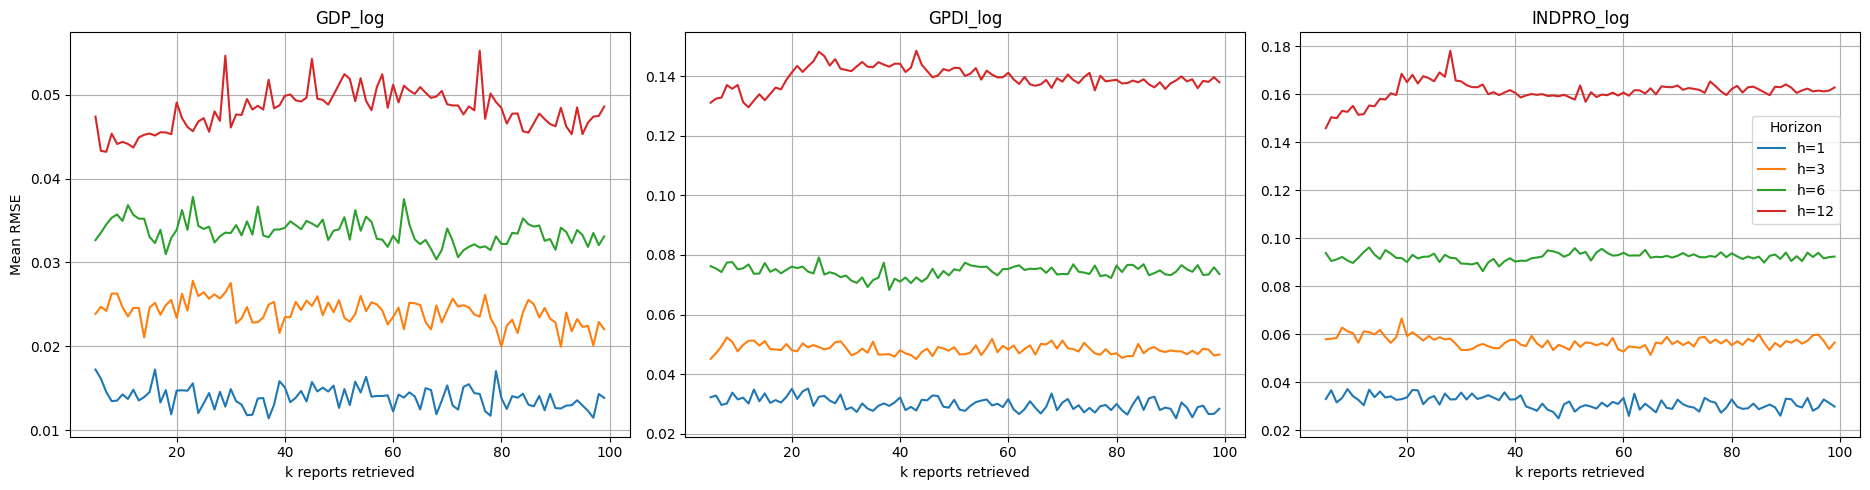

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=1):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Settings
window_size = 1
horizon_keys = list(moirai_k_results.keys())
k_values = moirai_k_results[horizon_keys[0]]["k"]
variables = list(moirai_k_results[horizon_keys[0]]["mean_rmses"].keys())

# Custom colors for horizons
horizon_colors = {
    'h=1': '#1f77b4',   # blue
    'h=3': '#ff7f0e',   # orange
    'h=6': '#2ca02c',   # green
    'h=12': '#d62728'   # red
}

# Create subplots with extra space for the legend
fig, axes = plt.subplots(1, len(variables), figsize=(20, 5), sharey=False)

for idx, var in enumerate(variables):
    ax = axes[idx]
    for h in horizon_keys:
        rmse_vals = moirai_k_results[h]["mean_rmses"][var]
        smoothed_vals = moving_average(rmse_vals, window_size)
        ax.plot(k_values, smoothed_vals, label=h, color=horizon_colors[h])

    ax.set_title(f"{var}")
    ax.set_xlabel("k reports retrieved")
    if idx == 0:
        ax.set_ylabel("Mean RMSE")
    ax.grid(True)

# Put legend to the right of the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title="Horizon", loc='center left', bbox_to_anchor=(0.875, 0.65))
plt.tight_layout(rect=[0, 0, 0.94, 1])  # Shrink layout less to keep legend nearby

plt.tight_layout(rect=[0, 0, 0.94, 1])
plt.savefig("/content/drive/MyDrive/THESIS/rag-thesis/results/rag_forecasting/moirai_k_plot.png", dpi=1000, bbox_inches='tight')
#plt.close()  # Optional: avoids showing the plot inline
